In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler #pour standaridiser les données
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats


In [652]:
import pickle

In [60]:
import math

In [653]:
df_billets = pd.read_csv('/Users/helmisaddem/Documents/billets.csv', sep=';')

In [5]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [7]:
df_billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [655]:
df_billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [654]:
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [656]:
billets_witnout_nan = df_billets.loc[
    ~df_billets.isna().any(axis='columns')]

In [ ]:
billets_witnout_nan.info()

In [657]:
print(f'Valeur(s) manquante(s) : {billets_witnout_nan.isna().any().any()}')

Valeur(s) manquante(s) : False


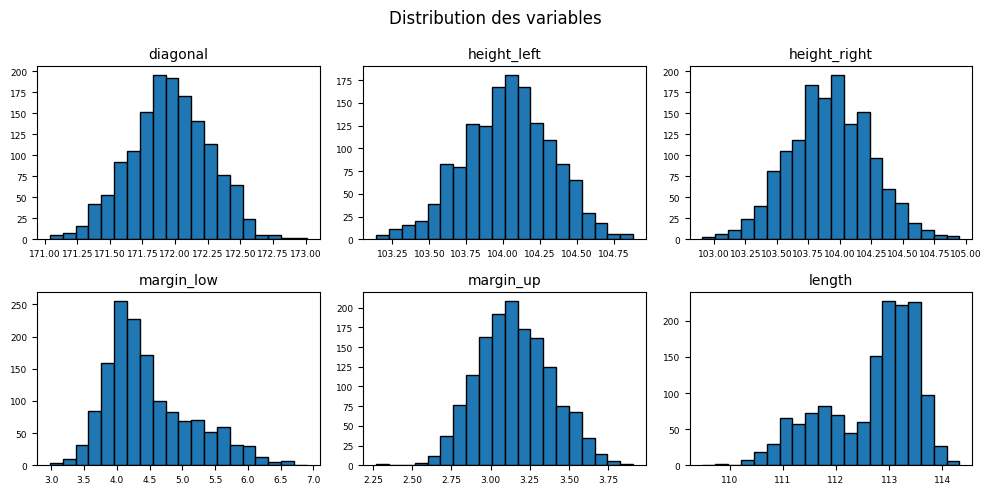

In [658]:
#Distribution des variables :
variables = df_billets.columns.to_list()
variables.remove('is_genuine')

fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i, var in enumerate(variables):
    r = i // 3
    c = i % 3
    axs[r, c].hist(var, data=billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                                  'margin_low', 'margin_up', 'length']], 
                   edgecolor='k', bins=20)
    axs[r, c].set_title(var, size=10)
    axs[r, c].tick_params(axis='both', which='both', labelsize=6.5)

# Supprime les graphiques vides
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.suptitle('Distribution des variables')

plt.tight_layout()

plt.show()

del fig, axs, i, r, c, var 

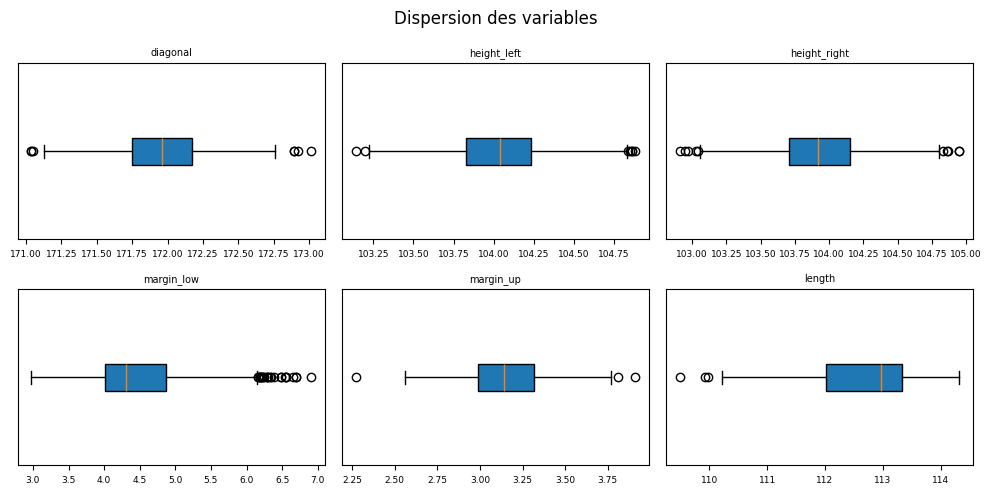

In [222]:
# Dispersion des variables 
variables = df_billets.columns.to_list()
variables.remove('is_genuine')

fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i, var in enumerate(variables):
    r = i // 3
    c = i % 3
    axs[r, c].boxplot(var, data=billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                                     'margin_low', 'margin_up', 'length']], 
                      patch_artist=True, vert=False)
    axs[r, c].set_title(var, size=7)
    axs[r, c].yaxis.set_major_locator(plt.NullLocator())
    axs[r, c].tick_params(axis='x', which='both', labelsize=6.5)


[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.suptitle('Dispersion des variables')

plt.tight_layout()

plt.show()

del fig, axs, i, var, r, c

In [223]:
#heatmap : corrélation entre les variables:
matrice_corr = billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                    'margin_low', 'margin_up', 'length']].corr(numeric_only=True, method='pearson')
matrice_corr.style.background_gradient(axis='rows', cmap='coolwarm').format('{:.2f}')



,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.00,0.02,-0.02,-0.11,-0.06,0.10
height_left,0.02,1.00,0.24,0.30,0.24,-0.31
height_right,-0.02,0.24,1.00,0.39,0.31,-0.40
margin_low,-0.11,0.30,0.39,1.00,0.43,-0.67
margin_up,-0.06,0.24,0.31,0.43,1.00,-0.52
length,0.10,-0.31,-0.40,-0.67,-0.52,1.00


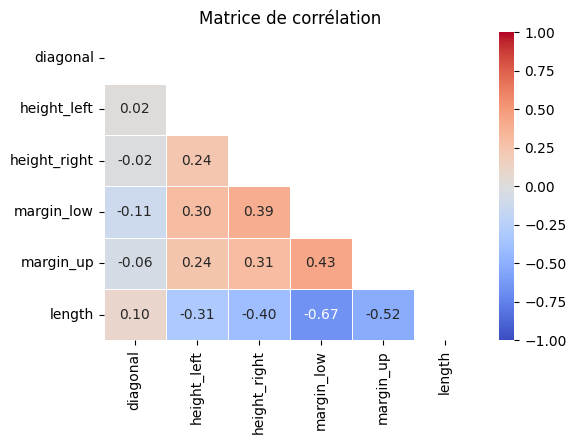

In [224]:
fig, ax = plt.subplots(figsize=(6, 4))
mask = np.triu(np.ones_like(matrice_corr, dtype=bool))
sns.heatmap(matrice_corr, annot=True, fmt='.2f', vmin=-1, vmax=1,
annot_kws=None, linewidths=0.6, cmap='coolwarm', ax=ax, mask=mask)

ax.set_title('Matrice de corrélation')

plt.show()

del fig, ax

Text(0, 0.5, 'margin_low')

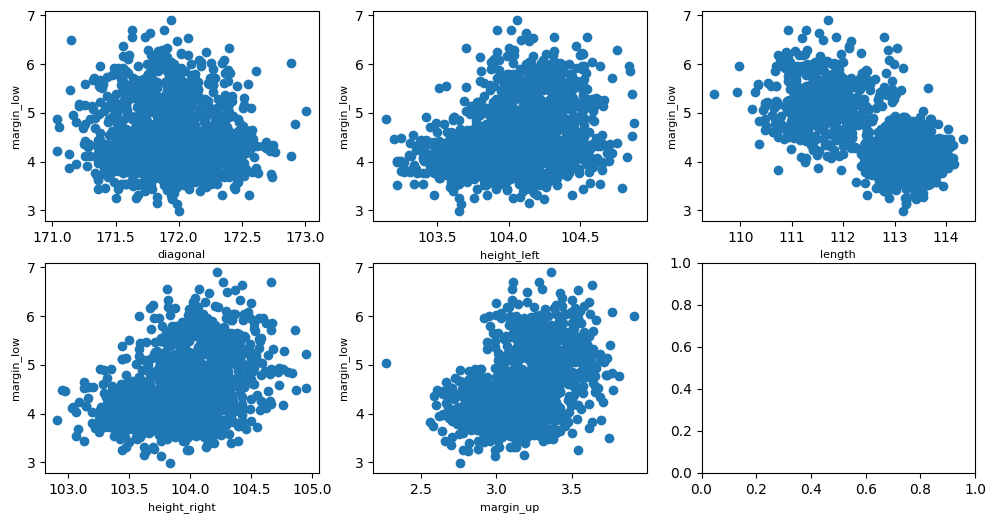

In [659]:
#scatter pour voir la linéarité entre la variable dépendante margin_low et les autres variables
variables = df_billets.columns.to_list()
variables.remove('is_genuine')
variables.remove('margin_low')

fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(12, 6))

i = 0
for r in range(2):
   for c in range(2):
       axs[r, c].scatter(billets_witnout_nan[variables[i]], billets_witnout_nan['margin_low'])
       axs[r, c].set_xlabel(variables[i], size=8)
       axs[r, c].set_ylabel('margin_low', size=8)
       i += 1
axs[0,2].scatter(billets_witnout_nan[variables[4]], billets_witnout_nan['margin_low'])
axs[0,2].set_xlabel(variables[4], size=8) 
axs[0,2].set_ylabel('margin_low', size=8)      



In [231]:
variables = df_billets.columns.to_list()
variables.remove('margin_low')
# Créer un modèle de régression linéaire
model = LinearRegression()

for i in range(5):
    #Adapater le modèle aux données
    model.fit(billets_witnout_nan[[variables[i]]], billets_witnout_nan['margin_low'])
    #coefficient de détermination
    r_squared = model.score(billets_witnout_nan[[variables[i]]], billets_witnout_nan['margin_low'])
    print('Coefficient de détermination ou R² entre',variables[i],'et margin_low', r_squared) #Coefficient de détermination (R²)
#Un R² proche de 1 indique que le modèle de régression linéaire ajusté explique 
# une grande partie de la variance de la variable dépendante. 




Coefficient de détermination ou R² entre is_genuine et margin_low 0.6131393378084237
Coefficient de détermination ou R² entre diagonal et margin_low 0.012439850430716826
Coefficient de détermination ou R² entre height_left et margin_low 0.09159276027592533
Coefficient de détermination ou R² entre height_right et margin_low 0.15294759201240649
Coefficient de détermination ou R² entre margin_up et margin_low 0.18628380252698062


In [76]:
#supprimer les outliers de margin low et revoir si la relation se linéarise : 
#Q1 = billets_witnout_nan['margin_low'].quantile(0.25)
#Q3 = billets_witnout_nan['margin_low'].quantile(0.75)
#IQR = Q3 - Q1
#max_boxplot = 1.5 * IQR + Q3
#min_boxplot = Q1 - 1.5 * IQR
#df = billets_witnout_nan.loc[
            #(billets_witnout_nan['margin_low'] < max_boxplot) & (billets_witnout_nan['margin_low'] > min_boxplot)]


In [ ]:
#px.box(data_frame= df, y='margin_low').update_layout(height=600, width=300)

Text(0, 0.5, 'margin_low')

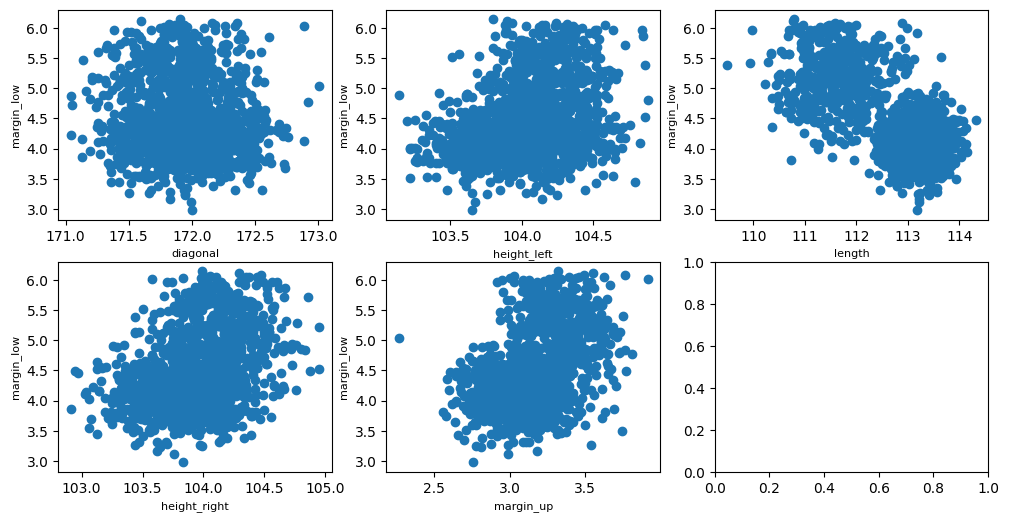

In [660]:
#scatter plot de margin_low en fonction du reste des variables après suppression des outliers:
fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(12, 6))

i = 0
for r in range(2):
   for c in range(2):
       axs[r, c].scatter(df[variables[i]], df['margin_low'])
       axs[r, c].set_xlabel(variables[i], size=8)
       axs[r, c].set_ylabel('margin_low', size=8)
       i += 1
axs[0,2].scatter(df[variables[4]], df['margin_low'])
axs[0,2].set_xlabel(variables[4], size=8)
axs[0,2].set_ylabel('margin_low', size=8) 

In [67]:
billets_witnout_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [661]:
# Créez un objet PolynomialFeatures pour une transformation polynomiale d'ordre 2
poly = PolynomialFeatures(degree=2)
# Appliquez la transformation polynomiale à vos données
X_poly = poly.fit_transform(billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                    'margin_up', 'length']])
# Convertissez les données transformées en un DataFrame pandas pour visualiser
original_feature_names = billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                    'margin_up', 'length']].columns.to_list()  
new_feature_names = poly.get_feature_names_out(original_feature_names)
X_poly_df = pd.DataFrame(X_poly, columns=new_feature_names)                                  


In [662]:
X_poly_df.drop('1', axis=1, inplace=True)

In [663]:

# créer une table avec margin low inclus:
poly = PolynomialFeatures(degree=2)
poly.fit(billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                    'margin_up', 'length', 'margin_low']])
names = billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                    'margin_up', 'length', 'margin_low']].columns.to_list()  
new_names = poly.get_feature_names_out(names)
X_poly_margin_low = poly.transform(billets_witnout_nan[['diagonal', 'height_left', 'height_right', 
                                    'margin_up', 'length', 'margin_low']])
X_poly_df_margin_low = pd.DataFrame(X_poly_margin_low, columns=new_names) 

In [664]:
X_poly_df_margin_low.drop('1', axis=1, inplace=True)

In [665]:
X_poly_df_margin_low = X_poly_df_margin_low.iloc[:,[5,6,7,8,9,10,12,13,14,15,17,18,19,21,22,24]]

In [666]:
X_poly_df_margin_low.describe()

,margin_low,diagonal^2,diagonal height_left,diagonal height_right,diagonal margin_up,diagonal length,height_left^2,height_left height_right,height_left margin_up,height_left length,height_right^2,height_right margin_up,height_right length,margin_up^2,margin_up length,length^2
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000
mean,4.485967,29570.057448,17889.145764,17870.251343,542.197380,19375.487251,10822.607922,10811.112528,328.036293,11721.623005,10799.778283,327.696021,11709.212775,9.995470,355.167568,12696.362938
std,0.663813,105.048572,61.023314,63.610612,39.753988,157.383190,62.328225,50.998731,24.332463,86.469862,67.380337,24.399170,83.090890,1.469298,24.722164,196.162230
min,2.980000,29254.681600,17708.739600,17650.348200,390.553500,18804.907500,10637.859600,10668.823700,235.399000,11382.580400,10590.468100,235.512500,11368.346700,5.152900,257.758500,11988.060100
25%,4.015000,29498.062500,17847.381400,17828.991050,513.861400,19262.065050,10779.630650,10775.476400,310.410000,11665.362000,10755.764100,310.110750,11658.562000,8.940100,337.572950,12548.480400
50%,4.310000,29570.241600,17891.352000,17868.644800,540.205600,19422.076600,10824.321600,10810.791600,326.748400,11737.528500,10799.366400,326.365100,11723.191400,9.859600,354.525600,12759.961600
75%,4.870000,29642.508900,17929.889700,17912.008100,569.994200,19494.981200,10863.892900,10846.595950,344.859400,11784.978400,10847.222500,344.782000,11768.928700,10.989250,372.713050,12845.955600
max,6.900000,29932.460100,18095.115900,18066.329400,672.363600,19693.715600,10999.814400,11005.057000,407.773900,11911.900000,11014.502500,406.757300,11893.620000,15.288100,433.345300,13069.062400


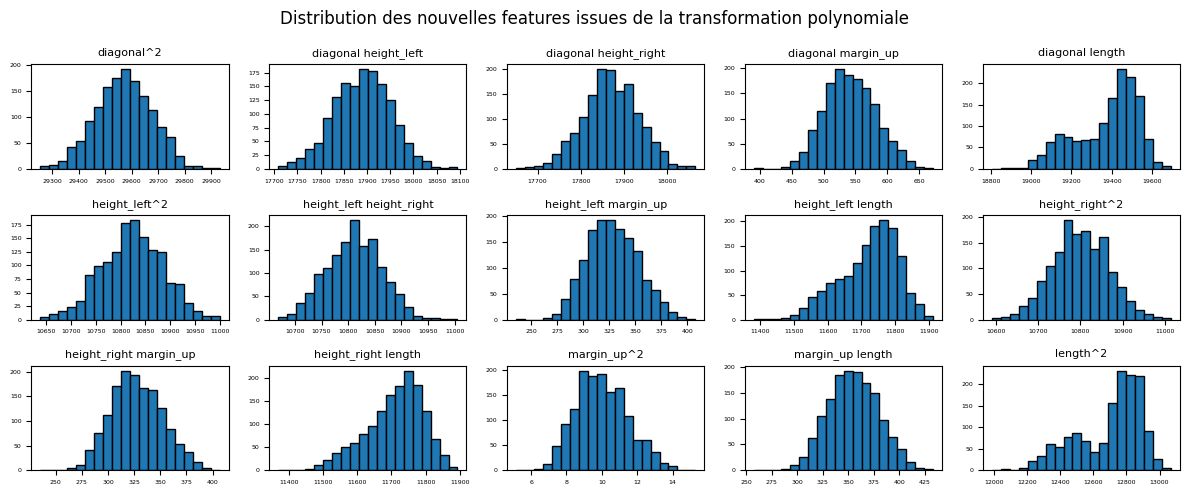

In [667]:
feature = X_poly_df.iloc[:,5:20].columns.to_list() 

fig, axs = plt.subplots(3, 5, figsize=(12, 5))
 

for i, var in enumerate(feature):
    r = i // 5
    c = i % 5
    axs[r, c].hist(var, data=X_poly_df.iloc[:,5:20],
                   edgecolor='k', bins=20)
    axs[r, c].set_title(var, size=8)
    axs[r, c].tick_params(axis='both', which='both', labelsize=4.5)

# Supprime les graphiques vides
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.suptitle('Distribution des nouvelles features issues de la transformation polynomiale')

plt.tight_layout()

plt.show()

del fig, axs, i, r, c, var

In [255]:
X_poly_df_margin_low.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   margin_low                1463 non-null   float64
 1   diagonal^2                1463 non-null   float64
 2   diagonal height_left      1463 non-null   float64
 3   diagonal height_right     1463 non-null   float64
 4   diagonal margin_up        1463 non-null   float64
 5   diagonal length           1463 non-null   float64
 6   height_left^2             1463 non-null   float64
 7   height_left height_right  1463 non-null   float64
 8   height_left margin_up     1463 non-null   float64
 9   height_left length        1463 non-null   float64
 10  height_right^2            1463 non-null   float64
 11  height_right margin_up    1463 non-null   float64
 12  height_right length       1463 non-null   float64
 13  margin_up^2               1463 non-null   float64
 14  margin_u

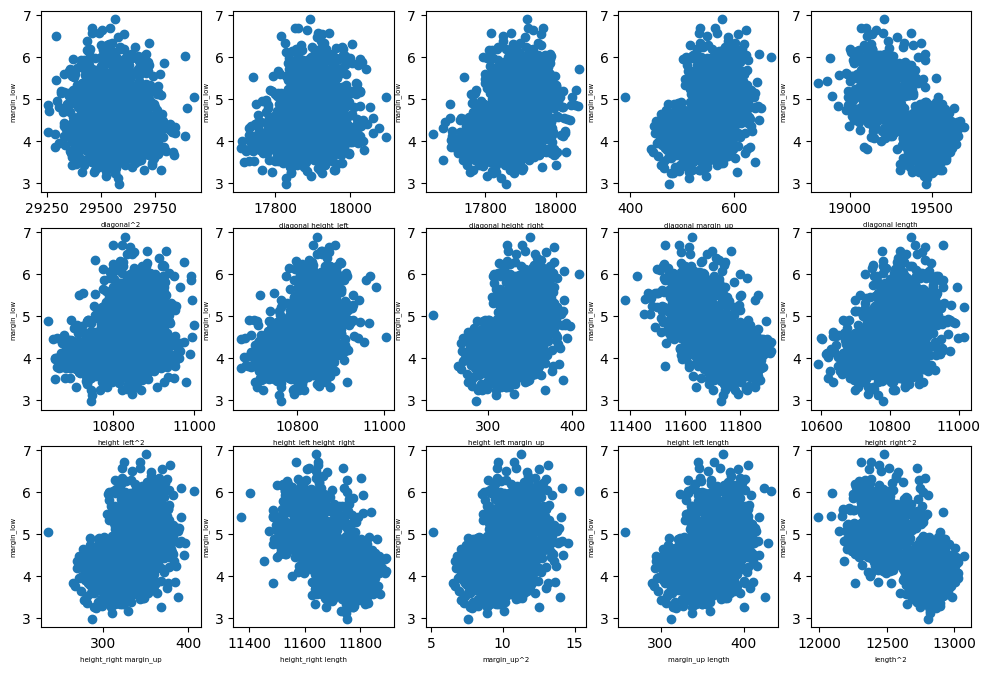

In [668]:
feature = X_poly_df_margin_low.iloc[:,1:16].columns.to_list()
fig, axs = plt.subplots(nrows=3, ncols=5,
                            figsize=(12, 8))

i = 0
for r in range(3):
   for c in range(5):
       axs[r, c].scatter(X_poly_df_margin_low[feature[i]], X_poly_df_margin_low['margin_low'])
       axs[r, c].set_xlabel(feature[i], size=5)
       axs[r, c].set_ylabel('margin_low', size=5)
       i += 1

In [669]:
#correlation entre nouvelles features et ma variable margin_low
matrice_corr = X_poly_df_margin_low.corr(numeric_only=True, method='pearson')
matrice_corr.style.background_gradient(axis='rows', cmap='coolwarm').format('{:.2f}')



,margin_low,diagonal^2,diagonal height_left,diagonal height_right,diagonal margin_up,diagonal length,height_left^2,height_left height_right,height_left margin_up,height_left length,height_right^2,height_right margin_up,height_right length,margin_up^2,margin_up length,length^2
margin_low,1.00,-0.11,0.20,0.29,0.43,-0.66,0.30,0.44,0.44,-0.58,0.39,0.44,-0.56,0.43,0.38,-0.67
diagonal^2,-0.11,1.00,0.54,0.48,-0.03,0.31,0.02,-0.00,-0.06,0.11,-0.02,-0.06,0.10,-0.06,-0.05,0.10
diagonal height_left,0.20,0.54,1.00,0.43,0.19,-0.09,0.85,0.65,0.21,0.11,0.19,0.18,-0.15,0.18,0.16,-0.21
diagonal height_right,0.29,0.48,0.43,1.00,0.25,-0.18,0.22,0.70,0.25,-0.24,0.87,0.27,0.05,0.24,0.22,-0.30
diagonal margin_up,0.43,-0.03,0.19,0.25,1.00,-0.50,0.24,0.35,1.00,-0.45,0.31,1.00,-0.43,1.00,1.00,-0.52
diagonal length,-0.66,0.31,-0.09,-0.18,-0.50,1.00,-0.30,-0.44,-0.52,0.91,-0.39,-0.52,0.90,-0.51,-0.43,0.98
height_left^2,0.30,0.02,0.85,0.22,0.24,-0.30,1.00,0.77,0.28,0.06,0.24,0.25,-0.24,0.24,0.22,-0.31
height_left height_right,0.44,-0.00,0.65,0.70,0.35,-0.44,0.77,1.00,0.38,-0.18,0.81,0.38,-0.15,0.36,0.32,-0.46
height_left margin_up,0.44,-0.06,0.21,0.25,1.00,-0.52,0.28,0.38,1.00,-0.45,0.31,1.00,-0.44,1.00,0.99,-0.53
height_left length,-0.58,0.11,0.11,-0.24,-0.45,0.91,0.06,-0.18,-0.45,1.00,-0.33,-0.46,0.87,-0.46,-0.37,0.93


In [670]:
# Calcul du R^2 pour chaque nouvelle feature et la margin_low
model = LinearRegression()
feature = X_poly_df_margin_low.columns.to_list()
feature.remove('margin_low')
for i in range(15):
    #Adapater le modèle aux données
    model.fit(X_poly_df_margin_low[[feature[i]]], X_poly_df_margin_low['margin_low'])
    #coefficient de détermination
    r_squared = model.score(X_poly_df_margin_low[[feature[i]]], X_poly_df_margin_low['margin_low'])
    print('Coefficient de détermination ou R² entre',feature[i],'et margin_low', r_squared) #Coefficient de détermination (R²)
#Un R² proche de 1 indique que le modèle de régression linéaire ajusté explique 
# une grande partie de la variance de la variable dépendante.

Coefficient de détermination ou R² entre diagonal^2 et margin_low 0.012441446892789365
Coefficient de détermination ou R² entre diagonal height_left et margin_low 0.038951449346347644
Coefficient de détermination ou R² entre diagonal height_right et margin_low 0.08233505895418802
Coefficient de détermination ou R² entre diagonal margin_up et margin_low 0.18434212368123915
Coefficient de détermination ou R² entre diagonal length et margin_low 0.436138729345381
Coefficient de détermination ou R² entre height_left^2 et margin_low 0.09155461917745966
Coefficient de détermination ou R² entre height_left height_right et margin_low 0.19678188236312044
Coefficient de détermination ou R² entre height_left margin_up et margin_low 0.19283511979378054
Coefficient de détermination ou R² entre height_left length et margin_low 0.33969262906533415
Coefficient de détermination ou R² entre height_right^2 et margin_low 0.15303504154890268
Coefficient de détermination ou R² entre height_right margin_up et

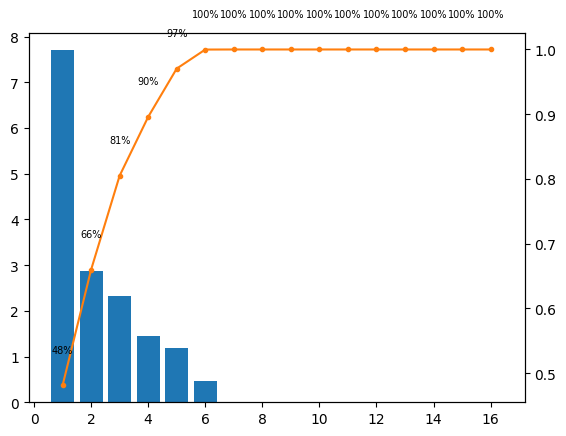

In [479]:
#PCA sur les nouvelles features :
from sklearn.decomposition import PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_poly_df_margin_low)
#Diagramme des éboulis : 
plt.bar(np.arange(1, (len(PCA().fit(data_scaled).explained_variance_)+1)), PCA().fit(data_scaled).explained_variance_)
plt.twinx()
plt.plot(np.arange(1, (len(PCA().fit(data_scaled).explained_variance_)+1)), PCA().fit(data_scaled).explained_variance_ratio_.cumsum(), color='C1', marker='.')
for x, y in enumerate(PCA().fit(data_scaled).explained_variance_ratio_.cumsum()):
    plt.text(x+1, (y+0.05) , f'{y:.0%}', ha='center', size=7)

In [271]:
def cercle_correlation_graph(dimension_sur_x, dimension_sur_y, pca=PCA(n_components=4).fit(data_scaled), text_offset=0.04):
  
    vecteurs_propres = pca.components_.T
    cum_variance_ratio = (pca.explained_variance_ratio_[dimension_sur_x]
                          + pca.explained_variance_ratio_[dimension_sur_y])

   
    fig, ax = plt.subplots(figsize=(6.4, 6.4))

    
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    ax.set_xlim(-1.02, 1.02)
    ax.set_ylim(-1.02, 1.02)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

    circle = plt.Circle((0, 0), 1, fill=False, linewidth=1, color='0.8')
    ax.add_patch(circle)
    ax.axhline(y=0, linestyle = '--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle = '--', linewidth=0.9, color='k')

   
    for i in range(len(vecteurs_propres)):
        
        ax.annotate(
            text='',
            xy=(vecteurs_propres[i, dimension_sur_x], vecteurs_propres[i, dimension_sur_y]),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', linewidth=0.8, color='b')
        )

       
        if vecteurs_propres[i, dimension_sur_x] > 0:
            h_offset=text_offset
        elif vecteurs_propres[i, dimension_sur_x] < 0:
            h_offset=-text_offset
        
        if vecteurs_propres[i, dimension_sur_y] > 0:
            v_offset=text_offset
        elif vecteurs_propres[i, dimension_sur_y] < 0:
            v_offset=-text_offset

        
        ax.text(
            x=(vecteurs_propres[i, dimension_sur_x]+h_offset), 
            y=(vecteurs_propres[i, dimension_sur_y]+v_offset),
            s=X_poly_df_margin_low.columns.to_list()[i], fontsize=8
        )

    
    ax.set_xlabel(f'CP{dimension_sur_x + 1} ({pca.explained_variance_ratio_[dimension_sur_x]:.1%})')
    ax.set_ylabel(f'CP{dimension_sur_y + 1} ({pca.explained_variance_ratio_[dimension_sur_y]:.1%})')

    ax.set_title(
        f'Cercle des corrélations\n'
        f'Composantes principales CP{dimension_sur_x + 1} et CP{dimension_sur_y + 1} ({cum_variance_ratio:.1%})', 
        fontsize= 9)

    plt.tight_layout()

    plt.show()

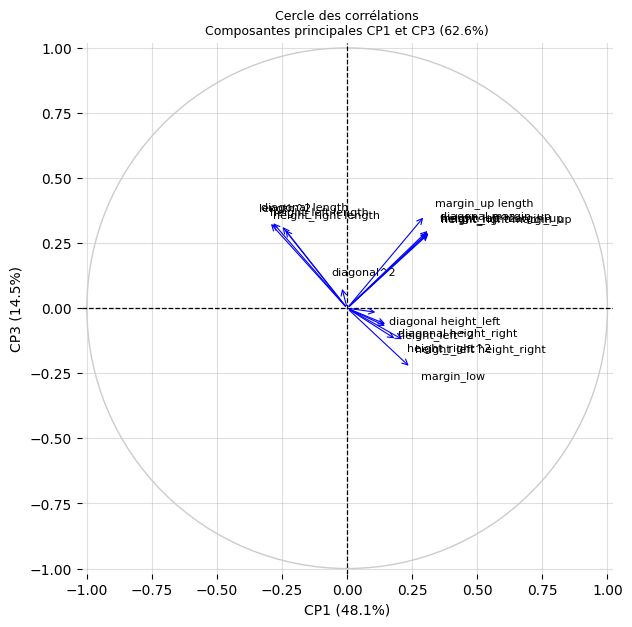

In [272]:
cercle_correlation_graph(0, 2)

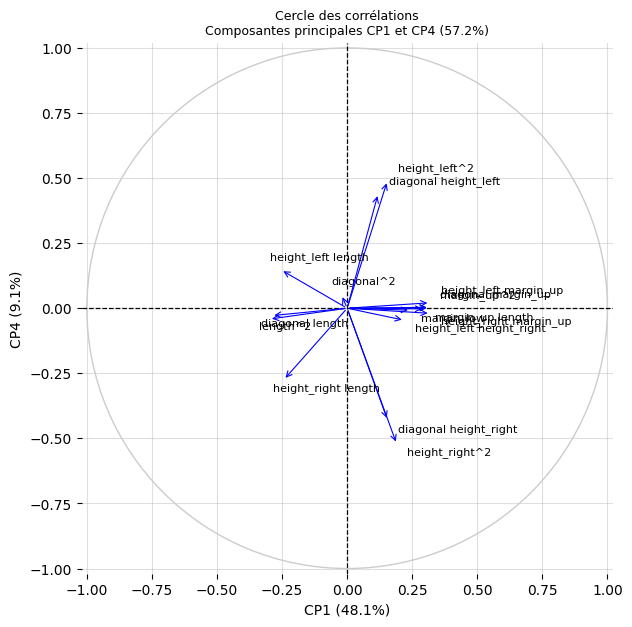

In [290]:
cercle_correlation_graph(0, 3)

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
# X est votre DataFrame contenant vos features, y est votre variable cible
billets_witnout_nan['diagonal_length'] = billets_witnout_nan['diagonal'] * billets_witnout_nan['length']
billets_witnout_nan['length^2'] = billets_witnout_nan['length'] * billets_witnout_nan['length']
X_train, X_test, y_train, y_test = train_test_split(billets_witnout_nan[['diagonal_length', 'length^2']], billets_witnout_nan['margin_low'], test_size=0.3, random_state=42)

In [274]:
df_billets['diagonal_length'] = df_billets['diagonal'] * df_billets['length']
df_billets['length^2'] = df_billets['length'] * df_billets['length']
# Créez et entraînez un modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédisez les valeurs manquantes dans la variable cible
missing_values = df_billets[df_billets['margin_low'].isna()][['diagonal_length', 'length^2']]  # features est la liste des features sélectionnées
predicted_values = model.predict(missing_values)

# Remplacez les valeurs manquantes par les valeurs prédites
df_billets.loc[df_billets['margin_low'].isna(), 'margin_low'] = predicted_values




In [281]:
#moyenne des valeurs manquantes prédites par notre régression linéaire 
print(predicted_values.mean())
print(predicted_values.std())


4.411567886045393
0.4232528658515769


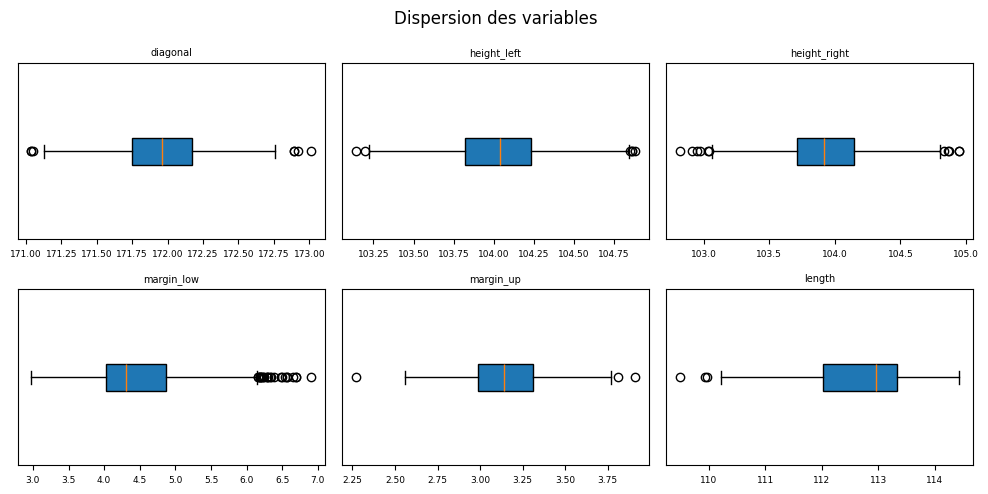

In [193]:
variables = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i, var in enumerate(variables):
    r = i // 3
    c = i % 3
    axs[r, c].boxplot(var, data=df_billets[['diagonal', 'height_left', 'height_right', 
                                                     'margin_low', 'margin_up', 'length']], 
                      patch_artist=True, vert=False)
    axs[r, c].set_title(var, size=7)
    axs[r, c].yaxis.set_major_locator(plt.NullLocator())
    axs[r, c].tick_params(axis='x', which='both', labelsize=6.5)


[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.suptitle('Dispersion des variables')

plt.tight_layout()

plt.show()

del fig, axs, i, var, r, c

In [643]:
df_billets.describe().style.background_gradient(axis='rows', cmap='coolwarm').format('{:.2f}')

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.48,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.02,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


In [196]:
#heatmap : corrélation entre les variables après traitement des 37 valeurs manquantes : 
matrice_corr = df_billets[['diagonal', 'height_left', 'height_right', 
                                    'margin_low', 'margin_up', 'length']].corr(numeric_only=True, method='pearson')
matrice_corr.style.background_gradient(axis='rows', cmap='coolwarm').format('{:.2f}')

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.00,0.02,-0.02,-0.11,-0.06,0.10
height_left,0.02,1.00,0.24,0.31,0.25,-0.32
height_right,-0.02,0.24,1.00,0.39,0.31,-0.40
margin_low,-0.11,0.31,0.39,1.00,0.43,-0.67
margin_up,-0.06,0.25,0.31,0.43,1.00,-0.52
length,0.10,-0.32,-0.40,-0.67,-0.52,1.00


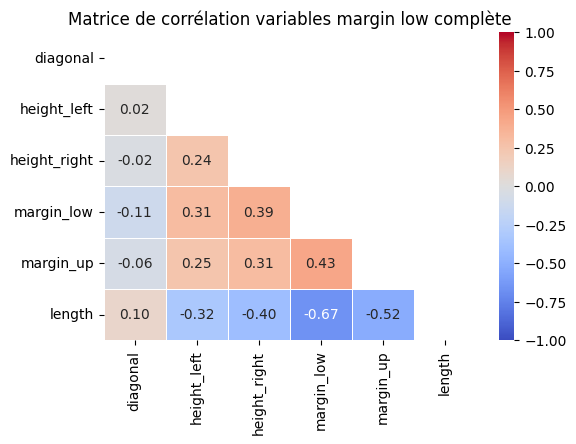

In [197]:
#Heatmap après traitement des 37 valeurs manquantes
fig, ax = plt.subplots(figsize=(6, 4))
mask = np.triu(np.ones_like(matrice_corr, dtype=bool))
sns.heatmap(matrice_corr, annot=True, fmt='.2f', vmin=-1, vmax=1,
annot_kws=None, linewidths=0.6, cmap='coolwarm', ax=ax, mask=mask)

ax.set_title('Matrice de corrélation variables margin low complète')

plt.show()

del fig, ax

In [284]:
#Vérification de la fiabilité de mon modèle de régression après transformation polynomiale: 
#Calculs des résidus : différence entre les valeurs observées et les valeurs prédites par le modèle: c'est à dire que je vais calculer des 
#valeurs selon mon modèle pour chaque valeur de ma partie test et je compare (différence) avec la valeur qu'on m'a donnée 
# Ils représentent l'erreur de prédiction pour chaque observation


X_train, X_test, y_train, y_test = train_test_split(df_billets[['diagonal_length', 'length^2']], df_billets['margin_low'], test_size=0.3, random_state=42)
y_pred = model.predict(X_test)
r2 = model.score(X_train, y_train)

In [289]:
mse = metrics.mean_squared_error(y_test, y_pred)
print(r2, mse)
# Calcule R² ajusté
n = len(y_test)
k = 2
ajusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))

# Affiche la valeur de R² ajusté
print(f'R2 ajusté : {ajusted_r2:.6f}')

del n, k, r2, ajusted_r2

0.4500029478337716 0.24015017406403918
R2 ajusté : 0.447542


In [ ]:
#Je vais essayer d'inclure 2 autres nouvelles features dans mon modèle et revoir si çà augmente sa fiabilité : 
# Diviser les données en ensembles d'entraînement et de test
# X est votre DataFrame contenant vos features, y est votre variable cible
#billets_witnout_nan['diagonal_length'] = billets_witnout_nan['diagonal'] * billets_witnout_nan['length']
#billets_witnout_nan['length^2'] = billets_witnout_nan['length'] * billets_witnout_nan['length']
billets_witnout_nan['height_right_length'] = billets_witnout_nan['height_right'] * billets_witnout_nan['length']
billets_witnout_nan['height_left_length'] = billets_witnout_nan['height_left'] * billets_witnout_nan['length']
X_train, X_test, y_train, y_test = train_test_split(billets_witnout_nan[['diagonal_length', 'length^2', 
                                                                         'height_right_length', 'height_left_length']], 
                                                    billets_witnout_nan['margin_low'], 
                                                    test_size=0.3, random_state=42)
df_billets = pd.read_csv('/Users/helmisaddem/Documents/billets.csv', sep=';')
df_billets['diagonal_length'] = df_billets['diagonal'] * df_billets['length']
df_billets['length^2'] = df_billets['length'] * df_billets['length']
df_billets['height_right_length'] = df_billets['height_right'] * df_billets['length']
df_billets['height_left_length'] = df_billets['height_left'] * df_billets['length']
# Créez et entraînez un modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédisez les valeurs manquantes dans la variable cible
missing_values = df_billets[df_billets['margin_low'].isna()][['diagonal_length', 'length^2', 'height_right_length', 'height_left_length']]  # features est la liste des features sélectionnées
predicted_values = model.predict(missing_values)

# Remplacez les valeurs manquantes par les valeurs prédites
df_billets.loc[df_billets['margin_low'].isna(), 'margin_low'] = predicted_values



In [673]:
X_train, X_test, y_train, y_test = train_test_split(df_billets[['diagonal_length', 'length^2', 'height_right_length', 'height_left_length']], 
                                                    df_billets['margin_low'], test_size=0.3, random_state=42)
y_pred = model.predict(X_test)
r2 = model.score(X_train, y_train)
print(r2)

#Reapplication du modèle avec 4 feature donne un r2 meilleur qu'avec seulement 2

0.47323524316395826


In [674]:
#R2 ajusté : 
n = len(y_test)
k = 4
ajusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))
print(ajusted_r2)


0.46850027905756686


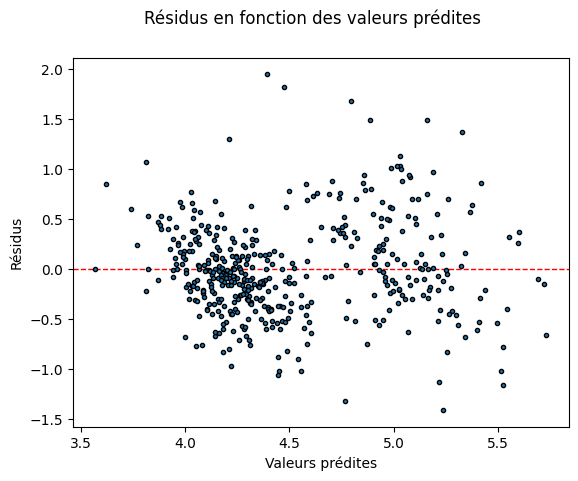

In [675]:
# Répartition des résidus en fonction des valeurs prédites : motifs aléatoires ?
residus = y_test - y_pred
fig, ax = plt.subplots()

ax.scatter(x=y_pred, y=residus, marker='.', edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

In [676]:
# Tester l'auto corrélation entre résidus par le test de Durbin-Watson:
print(f'Durbin-Watson : {durbin_watson(residus):.3f}')

# Tester l'homoscédasticité entre résidus par le test de Breusch-Pagan : 
print(f'p-value : {het_breuschpagan(residus, X_test.assign(constant=1))[1]:.3e}')

#Si la p-valeur est inférieure à un seuil de significativité donné (par exemple, 0,05), on rejette 
# l'hypothèse nulle selon laquelle il n'y a pas d'hétéroscédasticité dans le modèle. Cela signifie qu'il y a suffisamment 
# de preuves pour conclure que les résidus présentent une hétéroscédasticité statistiquement significative, 
# ce qui indique que la variance des erreurs de régression n'est pas constante à travers 
# toutes les valeurs de la variable indépendante.
#Si la p-valeur est supérieure au seuil de significativité, 
# on ne rejette pas l'hypothèse nulle. Cela signifie qu'il n'y a pas suffisamment de 
# preuves pour conclure à la présence d'une hétéroscédasticité statistiquement significative dans le modèle

Durbin-Watson : 1.927
p-value : 4.096e-04


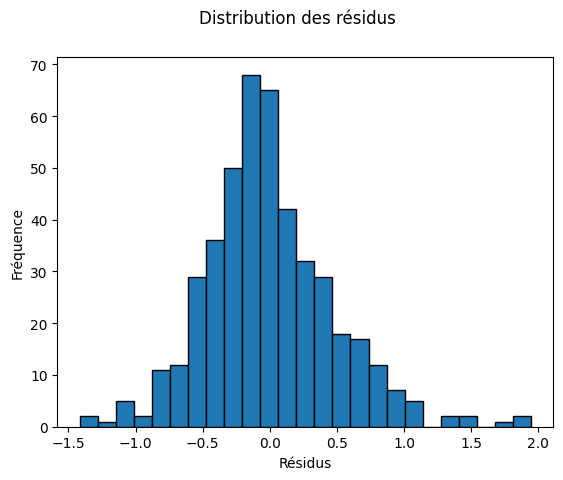

In [677]:
# Trace le graphique
fig, ax = plt.subplots()

ax.hist(x=residus, bins=25, edgecolor='k')
#ax.axvline(x=0, linestyle='--', linewidth=1, color='r')

ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
fig.suptitle('Distribution des résidus')

plt.show()

del fig, ax

Text(0, 0.5, '')

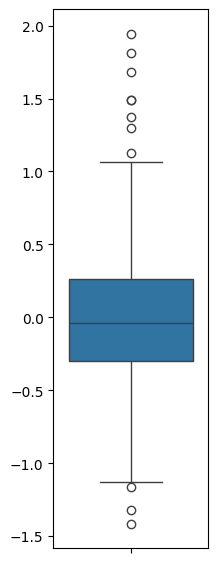

In [678]:
# Boxplot des résidus pour vérifier la normalité : 
plt.figure(figsize=(2, 7))
sns.boxplot(y=residus)
plt.ylabel("")



In [ ]:
# Une fois le dataset est complet, on va appliquer les algorithmes : K-Means, KNN, Random-Forest, Regression logistique  

In [679]:
# Vérification du nombre de vrais/faux billets
df_billets.drop(columns=['diagonal_length', 'length^2', 'height_right_length', 'height_left_length'], inplace=True)
df_billets['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

In [680]:
# Affichage de la moyenne et de la médiane des variables pour les vrais et faux billets
df_billets.groupby('is_genuine').agg({'mean', 'median'}).round(3).stack()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                      
False      mean     171.901      104.190       104.144       5.214      3.350   
           median   171.910      104.180       104.160       5.180      3.350   
True       mean     171.987      103.949       103.809       4.118      3.052   
           median   171.990      103.950       103.810       4.120      3.050   

                    length  
is_genuine                  
False      mean    111.631  
           median  111.630  
True       mean    113.202  
           median  113.205

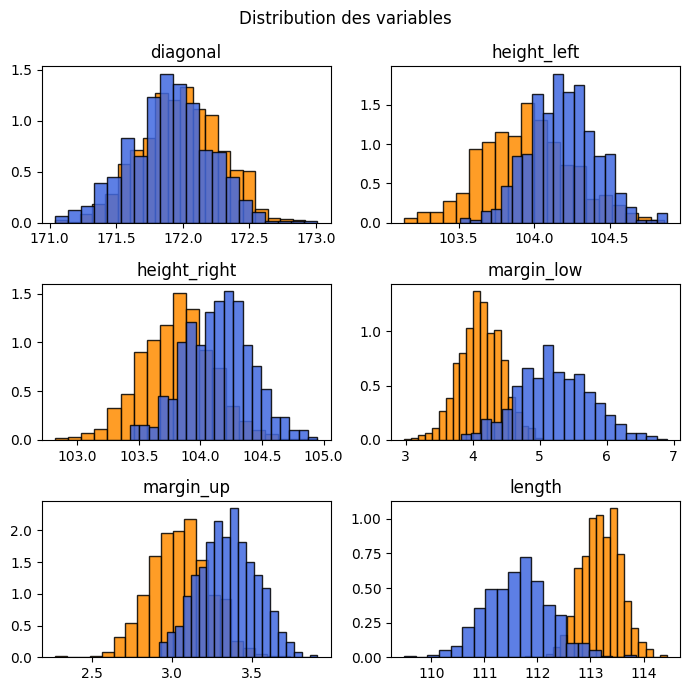

In [360]:
#Histogrammes genuine_True et genuine_False en fonction des différentes variables  
genuine_values = df_billets['is_genuine'].unique()

fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs = axs.flatten()
colors = ['darkorange', 'royalblue']
for i, column in enumerate(df_billets.columns[1:]):
    for j, k in enumerate(genuine_values):
        axs[i].hist(df_billets.loc[df_billets['is_genuine'] == k, column], alpha=0.85, bins=20, edgecolor='k', density=True, color= colors[j])
        axs[i].set_title(column, size=10)

fig.suptitle('Distribution des variables')

fig.tight_layout()

plt.show()

del genuine_values, colors, fig, axs, i, column, j, k

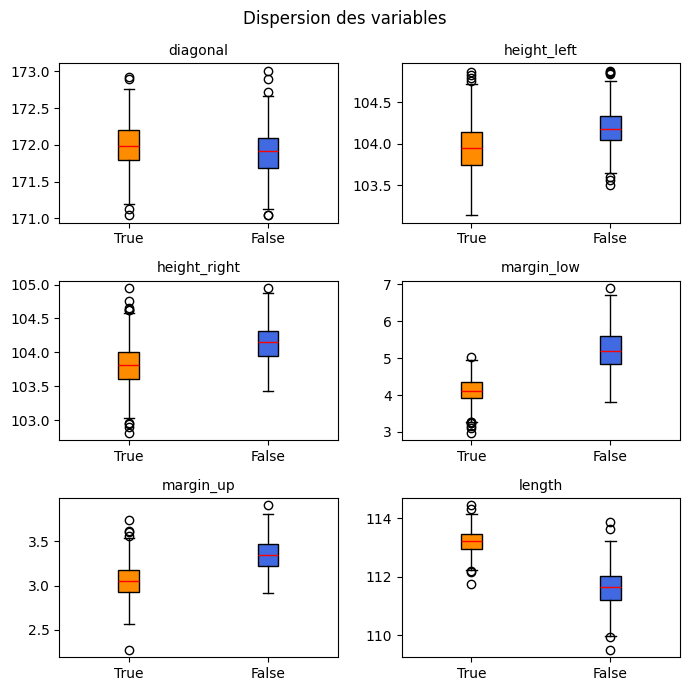

In [361]:
genuine_values = df_billets['is_genuine'].unique()
colors = ['darkorange', 'royalblue']
# Trace les boxplots de chaque variable
fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs = axs.flatten()

for i, column in enumerate(df_billets.columns[1:]):
    for j, k in enumerate(genuine_values):
        axs[i].boxplot(df_billets.loc[df_billets['is_genuine'] == k, column], positions=[j], patch_artist=True,  # Remplir les boîtes avec des couleurs
            boxprops=dict(facecolor= colors [j]), medianprops=dict(color='red'))  # Couleur des boîtes 
        axs[i].set_title(column, size =10)
        
    axs[i].set_xticklabels(genuine_values)

fig.suptitle('Dispersion des variables')

fig.tight_layout()

plt.show()

del genuine_values, fig, axs, i, column, j, k

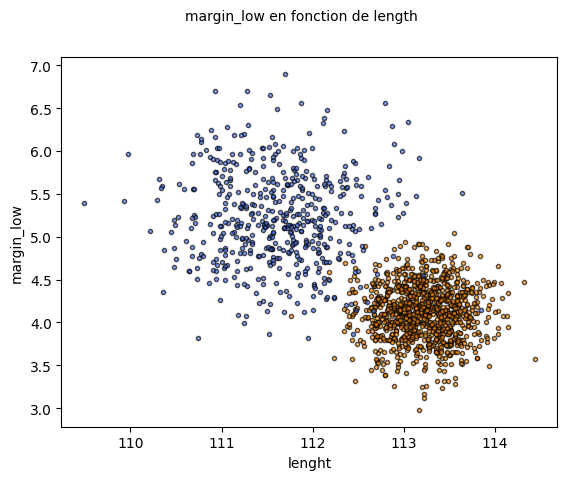

In [362]:
# 'margin_low' en fonction de 'length': 2 populations
fig, ax = plt.subplots()

ax.scatter(data=df_billets[df_billets['is_genuine'] == True],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65, color = 'darkorange')
ax.scatter(data=df_billets[df_billets['is_genuine'] == False],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65, color = 'royalblue')

ax.set_xlabel('lenght')
ax.set_ylabel('margin_low')

fig.suptitle('margin_low en fonction de length', size=10)

plt.show()

del fig, ax

In [368]:
df_billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [681]:
X_train, X_test, y_train, y_test = train_test_split(df_billets[['diagonal', 'height_left',
                                                                'height_right', 'margin_low',
                                                                'margin_up', 'length']], 
                                                    df_billets['is_genuine'], test_size=0.3, random_state=42)

In [552]:
# Fonction qui regroupe les crières d'évaluation d'un modèle :
def criteres_evaluation_model(y_test, y_pred): 
    metrics_results = pd.DataFrame({'accuracy': [metrics.accuracy_score(y_test, y_pred)],
              'recall_true': [metrics.recall_score(y_test, y_pred, pos_label=True)],     #sensibilité
              'recall_False': [metrics.recall_score(y_test, y_pred, pos_label=False)],   #spécificité 
              'precision_true': [metrics.precision_score(
            y_test, y_pred, pos_label=True)],     #VPP
              'precision_false': [metrics.precision_score(
            y_test, y_pred, pos_label=False)],      #VPN 
              'f1_score': [metrics.f1_score(
            y_test, y_pred, pos_label=False)]})
    return metrics_results


In [682]:
#Application des algorithmes de détection de faux billets 
#1- Régression Logistique: 

regression_logistiq = LogisticRegression()
regression_logistiq.fit(X_train, y_train)


y_pred = regression_logistiq.predict(X_test)
#plt.figure(figsize=(2, 4))
#plt.bar(['predicted_True', 'predicted_False'], [sum(y_pred), len(y_pred) - sum(y_pred)], color=['darkorange', 'royalblue'])
#plt.xticks(size=6)



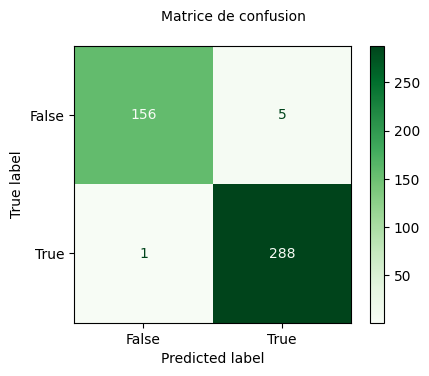

In [683]:
# Matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion', size=10)

plt.show()

del fig, ax

In [684]:
df1 = criteres_evaluation_model(y_test, y_pred)

In [ ]:
#Optimisation avec GridSearchCV : 
GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0),
    param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]}, scoring=metrics.make_scorer(
        metrics.f1_score, pos_label=False), cv=5).fit(
            X_train, y_train).best_params_

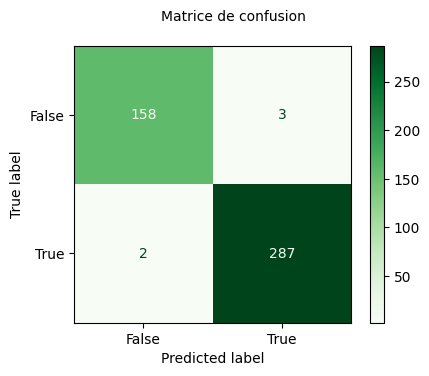

In [705]:
#Valeur optimale de C = 10: on va refaire la regression logistique en precisant C = 10 
y_pred = LogisticRegression(C=10, max_iter=100).fit(X_train, y_train).predict(X_test)
fig, ax = plt.subplots(figsize=(4.8, 3.6))

#Matrice de confusion:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')
fig.suptitle('Matrice de confusion', size=10)

plt.show()



In [687]:
# modele après optimisation :
df2 = criteres_evaluation_model(y_test, y_pred)
#Amélioration de la spécificité 0.98 contre 0.96

In [688]:
# Sauvegarde du modèle choisi 
with open('reg_logistiq.pkl', 'wb') as file:
    pickle.dump(LogisticRegression(C=10, max_iter=100).fit(X_train, y_train), file)
    


In [ ]:
#Il est important que l'algorithme soit plus précis sur la détection des faux billets que sur celle des vrais billets : 
# il est plus problématique de détecter les faux billet parmi les vrais 
# Ce sont donc les métriques des faux billets qui nous interesse

Confusion Matrix:
 [[159   2]
 [  2 287]]


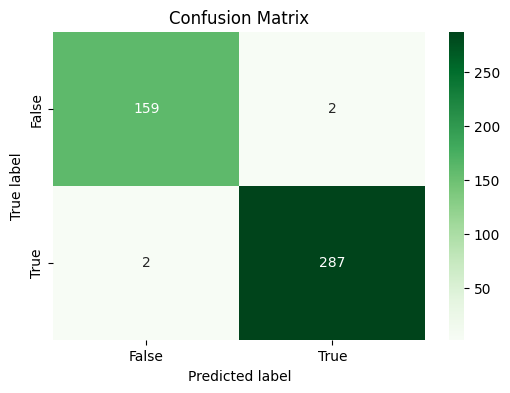

In [565]:
# 2eme méthode K-Means: normalisation nécessaires des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#cluster_labels = KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42).fit(X_train_scaled).labels_
#cluster_labels = np.asarray(cluster_labels)
#true_labels = y_train * 1

true_labels_test = y_test * 1


# Predict the clusters for the same training data
y_pred = KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42).fit(X_train_scaled).predict(X_test_scaled)

# Map the predicted cluster labels to the original true labels
mapped_predicted_labels = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = (y_pred == cluster)
    mapped_predicted_labels[mask] = mode(true_labels_test[mask])[0]

# Create confusion matrix with mapped predicted labels
conf_matrix = confusion_matrix(true_labels_test, mapped_predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=[False, True], yticklabels=[False, True])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()



In [567]:
df_3 = criteres_evaluation_model(true_labels_test, mapped_predicted_labels)

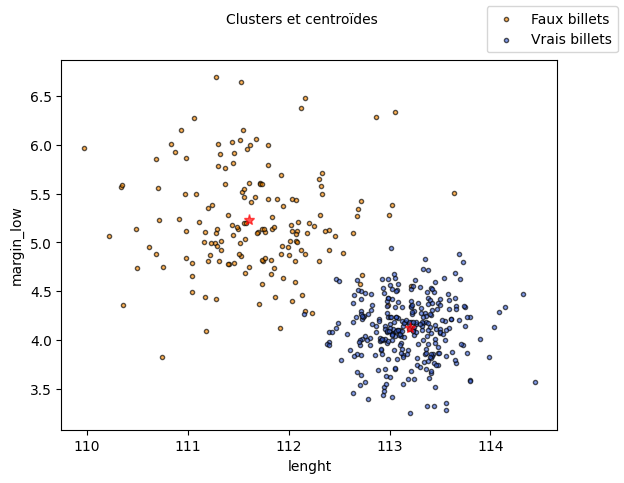

In [568]:
# Trace les clusters et leur centroïde avec 'margin_low' et 'length'
df_temp = X_test.copy()
df_temp['cluster'] = y_pred

fig, ax = plt.subplots()

ax.scatter(data=df_temp[df_temp['cluster'] == 1],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65, color = 'darkorange')
ax.scatter(data=df_temp[df_temp['cluster'] == 0],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65, color = 'royalblue')

ax.plot(scaler.inverse_transform(KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42).fit(X_train_scaled).cluster_centers_)[1][5],
        scaler.inverse_transform(KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42).fit(X_train_scaled).cluster_centers_)[1][3],
        marker='*', markersize=8, color='r', alpha=0.65)

ax.plot(scaler.inverse_transform(KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42).fit(X_train_scaled).cluster_centers_)[0][5],
        scaler.inverse_transform(KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42).fit(X_train_scaled).cluster_centers_)[0][3],
        marker='*', markersize=8, color='r', alpha=0.65)

ax.set_xlabel('lenght')
ax.set_ylabel('margin_low')

fig.suptitle('Clusters et centroïdes', size=10)

fig.legend(['Faux billets', 'Vrais billets'])

plt.show()

del fig, ax, df_temp

In [569]:
# Calcul 'accuracy' pour 5 'folds'
scoring = metrics.make_scorer(metrics.f1_score, pos_label=False)
scores = cross_val_score(
    KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42),
    X_train_scaled, y_train, cv=5, scoring=scoring
)

# Affiche les résulatats
print(
    f'f1-score_Faux_billets\n'
    f'min. :\t{np.min(scores):.6f}\n'
    f'max. :\t{np.max(scores):.6f}\n'
    f'moy. :\t{np.average(scores):.6f}'
)

del scores

f1-score_Faux_billets
min. :	0.967213
max. :	0.983051
moy. :	0.974873


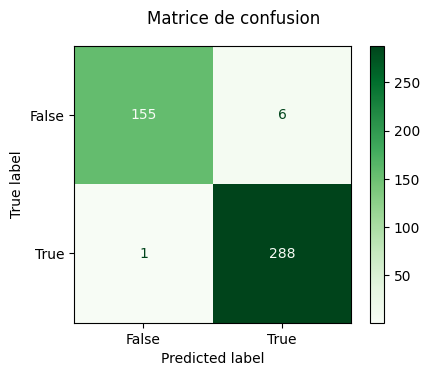

In [570]:
# Méthode 3 : KNN sans optimisation
y_pred = KNeighborsClassifier(n_neighbors=3).fit(X_train_scaled, y_train).predict(X_test_scaled)

# Matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [572]:
df_4 = criteres_evaluation_model(y_test, y_pred)

In [573]:
# Optimisation de KNN avec GridSearchCV:
param_grid = {
    'n_neighbors' : np.arange(1, 100, 3)
}

scoring = metrics.make_scorer(metrics.f1_score, pos_label=False)


# Meilleur paramètre
print(GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid, scoring=scoring, cv=5).fit(X_train_scaled, y_train).best_params_)

del param_grid

{'n_neighbors': 10}


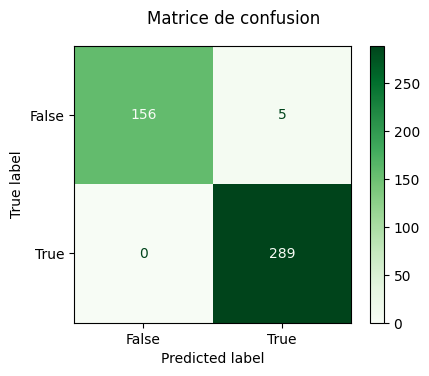

In [574]:
# Prediction avec KNN en précisant n neighbors 10
y_pred = KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train).predict(X_test_scaled)

# Matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [576]:
df_5 = criteres_evaluation_model(y_test, y_pred)

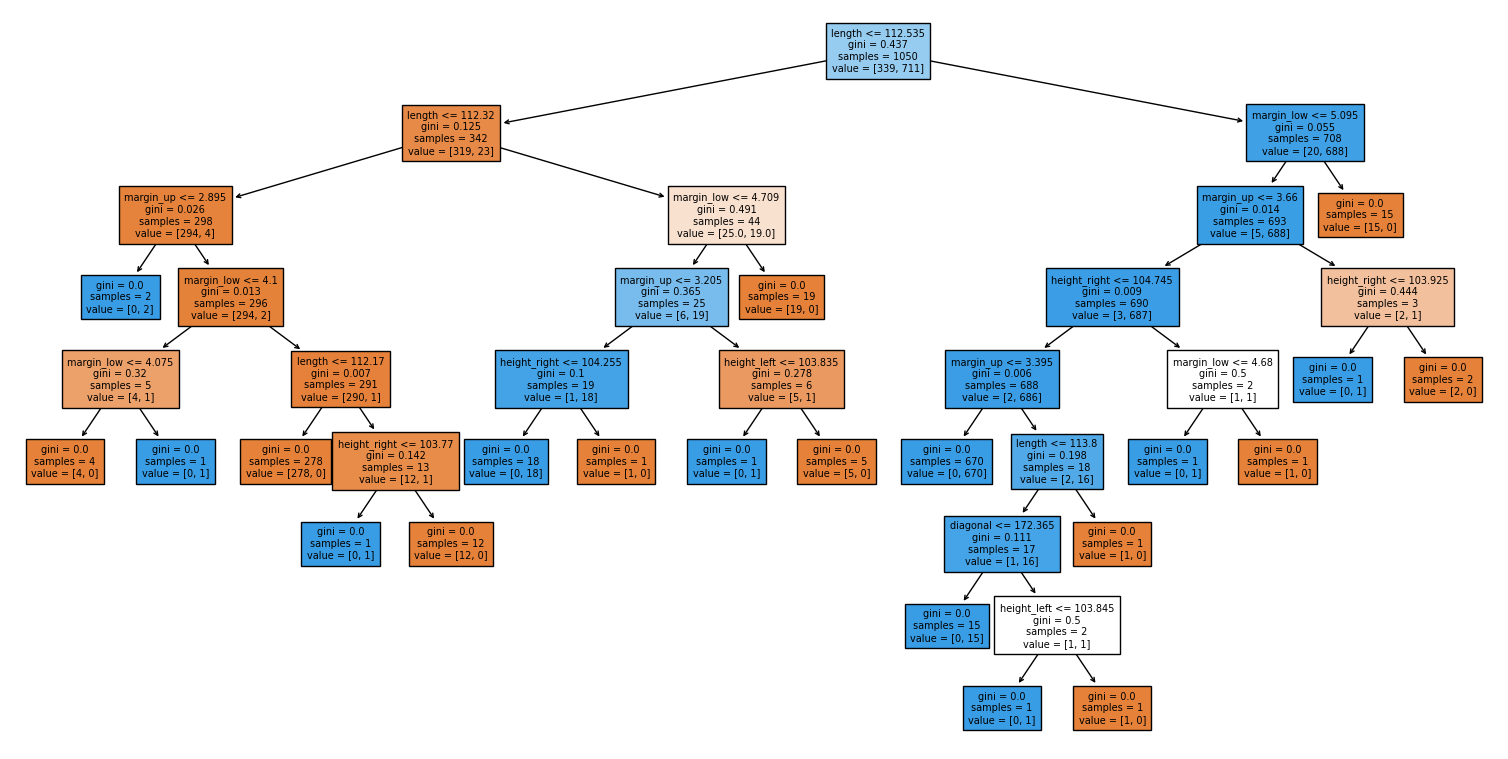

In [599]:
# Méthode 4 : Arbre de décision 
y_pred = DecisionTreeClassifier(random_state=0).fit(X_train, y_train).predict(X_test)


fig, ax = plt.subplots(figsize=(19.2, 9.6))
plot_tree(DecisionTreeClassifier(random_state=0).fit(X_train, y_train), feature_names=X_train.columns, filled=True, fontsize=7, ax=ax)
plt.show()

#df_billets[['diagonal', 'height_left',
#'height_right', 'margin_low',
#'margin_up', 'length']]

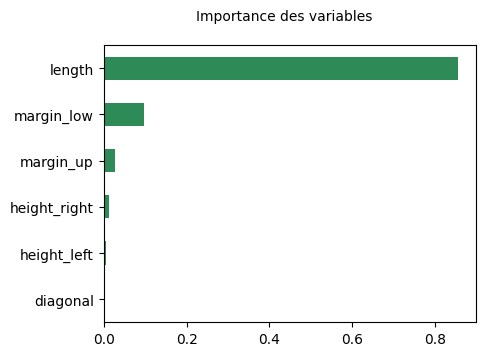

In [600]:
# Importance des variables : 
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    DecisionTreeClassifier(random_state=0).fit(X_train, y_train).feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax, color='seagreen')

ax.get_legend().remove()

fig.suptitle('Importance des variables', size=10)

plt.show()

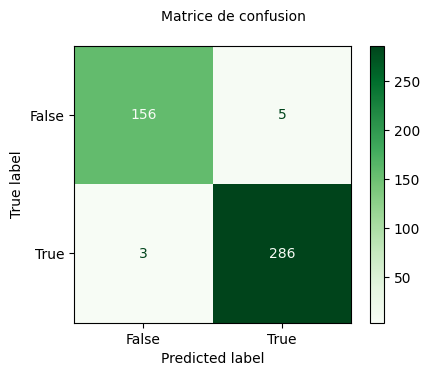

In [601]:
# Matrice de confusion de l'arbre de décision :

fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion', size=10)

plt.show()

del fig, ax

In [602]:
df_6 = criteres_evaluation_model(y_test, y_pred)

In [689]:
# Optimisation GridSearchCV : 
param_grid = {
    'max_depth' : np.arange(start=1, stop=200, step=10),
    'min_samples_leaf' : np.arange(start=5, stop=250, step=50),
    'min_samples_split' : np.arange(start=10, stop=500, step=50)
}

print(GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5).fit(X_train, y_train).best_params_)

del param_grid

{'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 310}


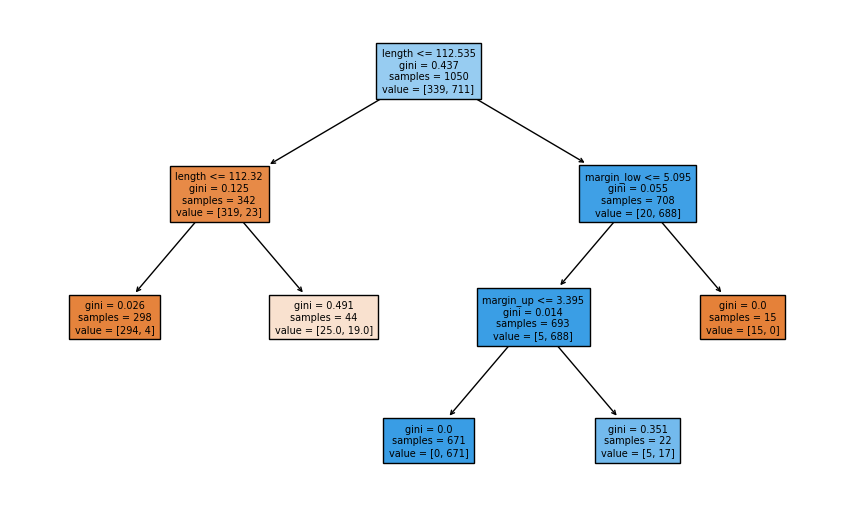

In [690]:


y_pred = DecisionTreeClassifier(
    max_depth=11, min_samples_leaf=5, min_samples_split=310).fit(X_train, y_train).predict(X_test)

fig, ax = plt.subplots(figsize=(10.8, 6.4))
plot_tree(DecisionTreeClassifier(
    max_depth=11, min_samples_leaf=5, min_samples_split=310).fit(X_train, y_train), feature_names=df_billets[['diagonal', 'height_left',
                                                                                                       'height_right', 'margin_low',
                                                                                    'margin_up', 'length']].columns, filled=True, fontsize=7, ax=ax)
plt.show()

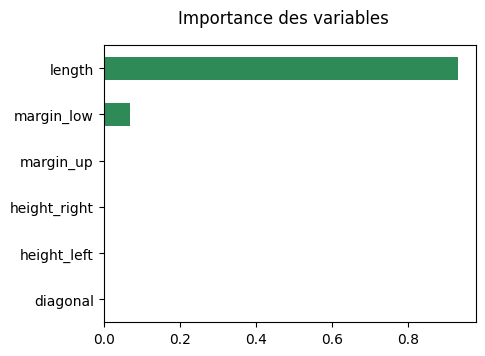

In [605]:
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    DecisionTreeClassifier(
    max_depth=11, min_samples_leaf=5, min_samples_split=310).fit(X_train, y_train).feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax, color='seagreen')
                                        

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

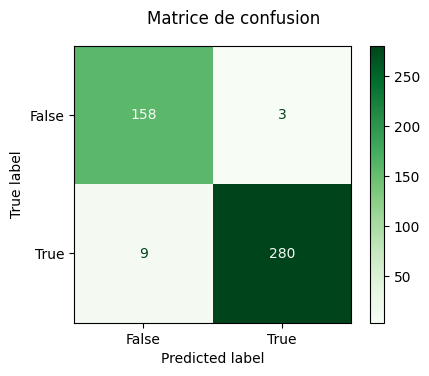

In [606]:
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [607]:
df_7 = criteres_evaluation_model(y_test, y_pred)

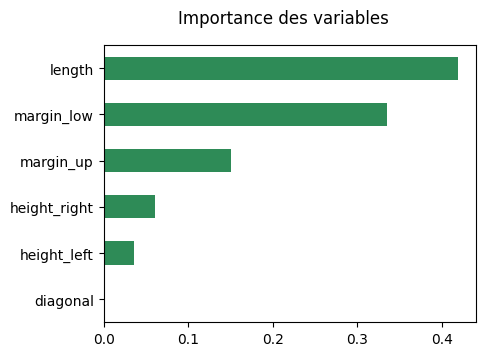

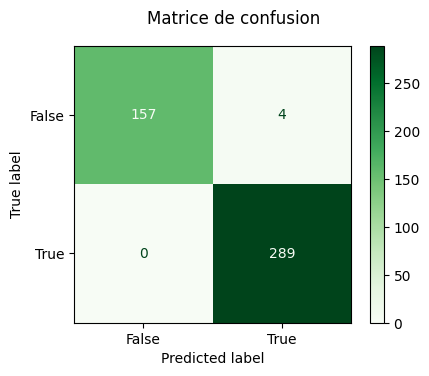

In [608]:
# Méthode 5 : Random forest : forêt aléatoire 
y_pred = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train).predict(X_test)

# Importance des variables : 
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train).feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax, color='seagreen')

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

# Matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [609]:
df_8 = criteres_evaluation_model(y_test, y_pred)

In [693]:
# Optimisation de la forêt aléatoire avec GridSearchCV : 
param_grid = {
    #'n_estimators': np.arange(start=1, stop=6, step=1),
    'max_depth': np.arange(start=1, stop=200, step=10),
    'min_samples_leaf': np.arange(start=5, stop=50, step=10),
    'min_samples_split': np.arange(start=10, stop=100, step=50)
}
# meilleur paramètre
print(GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5).fit(X_train, y_train).best_params_)

del param_grid


KeyboardInterrupt



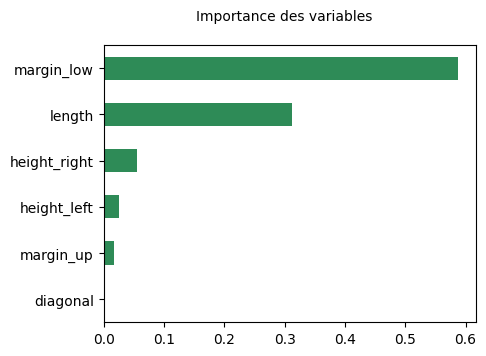

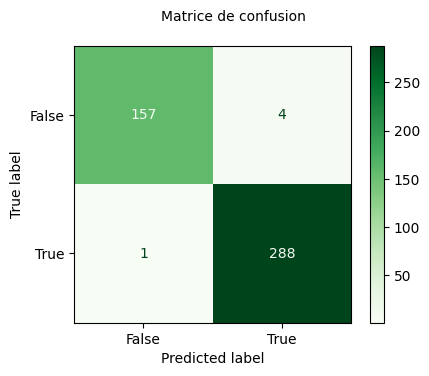

In [696]:
# Prédiction après optimisation:
y_pred = RandomForestClassifier( #n_estimators=5, 
    max_depth=10, min_samples_leaf=5, min_samples_split=10,
    random_state=0
).fit(X_train, y_train).predict(X_test)

# Importance des variables après optimisation
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    RandomForestClassifier(  n_estimators=5,
    max_depth=10, min_samples_leaf=5, min_samples_split=10,
    random_state=0
).fit(X_train, y_train).feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax, color='seagreen')

ax.get_legend().remove()

fig.suptitle('Importance des variables', size = 10)

plt.show()

fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Greens')

fig.suptitle('Matrice de confusion', size = 10)

plt.show()

del fig, ax

In [697]:
df_9 = criteres_evaluation_model(y_test, y_pred)


In [617]:
recap_table = pd.concat([df1, df2, df_3, df_4, df_5, df_6, df_7, df_8, df_9], ignore_index=True)

In [618]:
list = ['Regression_logistiq', 'Regression_logistiq_optimise', 'K_means', 
        'KNN', 'KNN_optimise', 'Arbre_decision', 
        'Arbre_decision_optimise', 'Foret_aleatoire', 'foret_aleatoire_optimise']
recap_table.insert(0, 'Model', list)

In [698]:
recap_table.head(10)

,Model,accuracy,recall_true,recall_False,precision_true,precision_false,f1_score
0,Regression_logistiq,0.986667,0.996540,0.968944,0.982935,0.993631,0.981132
1,Regression_logistiq_optimise,0.988889,0.993080,0.981366,0.989655,0.987500,0.984424
2,K_means,0.991111,0.993080,0.987578,0.993080,0.987578,0.987578
3,KNN,0.984444,0.996540,0.962733,0.979592,0.993590,0.977918
4,KNN_optimise,0.988889,1.000000,0.968944,0.982993,1.000000,0.984227
5,Arbre_decision,0.982222,0.989619,0.968944,0.982818,0.981132,0.975000
6,Arbre_decision_optimise,0.973333,0.968858,0.981366,0.989399,0.946108,0.963415
7,Foret_aleatoire,0.991111,1.000000,0.975155,0.986348,1.000000,0.987421
8,foret_aleatoire_optimise,0.984444,0.989619,0.975155,0.986207,0.981250,0.978193


In [651]:
recap_table.head(10).style.background_gradient(axis='rows', cmap='Blues').format('{:.2}') 

,Model,accuracy,recall_true,recall_False,precision_true,precision_false,f1_score
0,Re,0.99,1.0,0.97,0.98,0.99,0.98
1,Re,0.99,0.99,0.98,0.99,0.99,0.98
2,K_,0.99,0.99,0.99,0.99,0.99,0.99
3,KN,0.98,1.0,0.96,0.98,0.99,0.98
4,KN,0.99,1.0,0.97,0.98,1.0,0.98
5,Ar,0.98,0.99,0.97,0.98,0.98,0.97
6,Ar,0.97,0.97,0.98,0.99,0.95,0.96
7,Fo,0.99,1.0,0.98,0.99,1.0,0.99
8,fo,0.98,0.99,0.98,0.99,0.98,0.98


In [ ]:
#metrics.accuracy_score(y_test, y_pred)
#metrics.recall_score(y_test, y_pred, pos_label=True)
#metrics.recall_score(y_test, y_pred, pos_label=False)
#metrics.precision_score(
            #true_labels_test, mapped_predicted_labels, pos_label=True) # VPP
#metrics.precision_score(
            #true_labels_test, mapped_predicted_labels, pos_label=False) #VPN
#metrics.f1_score(
            #y_test, y_pred, pos_label=False)


In [628]:
df_billets.to_csv('/Users/helmisaddem/Downloads/billets.csv',index=False) 